# Mood-RL Ordinal Regression

## Section 1: Motivating the model

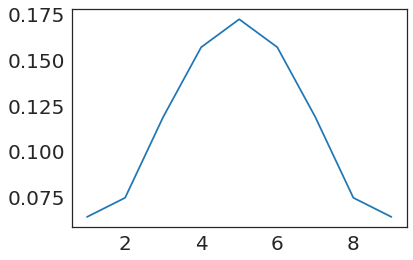

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

categories = np.arange(1,10)
cutpoints = np.arange(categories.min() + 0.5, categories.max(), 1)
C = categories.size

mu = 5
sd = 2.3

p = np.zeros(C)
p[0] = norm(loc=mu, scale=sd).cdf(cutpoints[0])
for i in np.arange(1,C-1):
    p[i] = norm(loc=mu, scale=sd).cdf(cutpoints[i]) - norm(loc=mu, scale=sd).cdf(cutpoints[i-1])
p[-1] = 1 - norm(loc=mu, scale=sd).cdf(cutpoints[-1])
    
plt.plot(categories, p)

## Section 2: Model fitting

In [ ]:
import os, pystan
import _pickle as cPickle
from pandas import DataFrame, read_csv
from scripts.diagnostics import check_div, check_energy, check_treedepth
%load_ext jupyternotify

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Select model.
model_name = 'moodRL_ordinal_no_mood.stan'

## Sampling parameters.
samples = 2500
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load and prepare behavior data.
data = read_csv('data/moodRL_data.csv')
data = data[data.Block < 4]

## Load and prepare ratings data.
ratings = read_csv('data/moodRL_ratings.csv')
ratings = ratings[ratings.Variable=='Mood']

## Load and prepare metadata.
metadata = read_csv('data/moodRL_metadata.csv')

## Extract and prepare stimulus presentation data.
## Stimulus presentation is sorted such that the
## more valuable machine occupies the right column.
X = data[['M1','M2']].values
X = np.sort(X, axis=-1) 

## Extract and prepare choice data. Choice data 
## recoded to range [1, 2], where 1 = less valuable, 
# 2 = more valuable. 
Y = data.Choice.values
Y = np.equal(X[:,-1], Y).astype(int)

## Extract and prepare reward data. All rewards 
## scaled between [0,1].
R = data.Outcome.values
R = np.where(R > 0, 1, 0)

## Extract and prepare mood data. All data
## scaled between [1,9].
M = ratings.loc[ratings.Trial>0, 'Rating'].values
M += 5

## Define subject index.
_, subj_ix = np.unique(data.Subject, return_inverse=True)
subj_ix += 1

## Define mood index.
mood_ix = np.in1d(data.Trial, [7,21,35]).astype(int)
shift, = np.where(np.logical_and(mood_ix, data.Choice.isnull()))
mood_ix[shift] = 0
mood_ix[shift-1] = 1
mood_ix[np.where(mood_ix)] = np.arange(mood_ix.sum()) + 1

## Remove trials with missing data.
X = X[data.Choice.notnull()]
Y = Y[data.Choice.notnull()]
R = R[data.Choice.notnull()]
subj_ix = subj_ix[data.Choice.notnull()]
mood_ix = mood_ix[data.Choice.notnull()]

## Define metadata.
data = data.dropna()
trials = data.Trial.values
blocks = data.Block.values

N = data.Subject.max()
T = Y.size
C = 9

## Organize data dictionary.
dd = dict(N=N, T=T, C=C, subj_ix=subj_ix, mood_ix=mood_ix, 
          X=X, Y=Y, R=R, M=M, blocks=blocks, trials=trials)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model with Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

if model_name:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Model fitting and diagnostics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Fit model.
    file = 'stan_models/%s' %model_name
    fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin, chains=chains, 
                      n_jobs=n_jobs, seed=47404)
    check_div(fit); check_treedepth(fit); check_energy(fit)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Save data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Create out-directory.
    out_dir = 'stan_fits/%s' %model_name.replace('.stan','')
    if not os.path.isdir(out_dir): os.makedirs(out_dir)

    ## Save summary file.
    summary = fit.summary()
    summary = DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
    summary.to_csv(os.path.join(out_dir, 'summary.csv'))

    ## Save contents of StanFit.
    extract = fit.extract()
    for k, v in dd.items(): extract[k] = v
    with open(os.path.join(out_dir, 'StanFit.pickle'), 'wb') as fn: cPickle.dump(extract, fn)
        
    print('Done.')

<IPython.core.display.Javascript object>

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9a5c3e6dca7b69fcd850c519cc714c9f NOW.


In [ ]:
%%notify
summary[summary.Rhat > 1.1]